# Vehicle Detection And Tracking

## Import libraries

In [1]:
from moviepy.editor import VideoFileClip

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import cv2

import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np

import os

import time

In [2]:
# Debug variable to print output
DBG = False#True

## Feature vector parameters

In [3]:
#Define features values
color_space = 'YCrCb'

# Bin spatial feature - size to reduce image to
spatial_size = (16, 16)

# Color Histogram feature - No of histogram bins
hist_bins = 16
# Color Histogram feature - Histogram color range
hist_range=(0, 256)

# HOG feature - orientations
orient = 9
# HOG feature - No of pixels per cell
pix_per_cell = 8
# HOG feature - No of cells per block
cell_per_block = 2
# HOG feature - Channel to extract hog feature
hog_channel = 'ALL'

#Spatial features on or off
spatial_feat = True
#Histogram features on or off
hist_feat = True 
#HOG features on or off
hog_feat = True

y_start_stop = [400, 656]

scales = [1, 1.25, 1.5, 1.75, 2]

## Load car and non-car images

In [4]:
dataset_base_dir = 'dataset/'
car_dataset = 'vehicles/'
noncar_dataset = 'non-vehicles/'

cars = []
noncars = []

# Get different folders inside the car dataset
img_types = os.listdir(dataset_base_dir + car_dataset)

for folder in img_types:
    cars.extend(glob.glob(dataset_base_dir + car_dataset + folder + '/*'))

# Get different folders inside the noncar dataset
img_types = os.listdir(dataset_base_dir + noncar_dataset)

for folder in img_types:
    noncars.extend(glob.glob(dataset_base_dir + noncar_dataset + folder + '/*'))

    
print("Total number of Cars in dataset: {}".format(len(cars)))
print("Total number of Non-Cars in dataset: {}".format(len(noncars)))

Total number of Cars in dataset: 8792
Total number of Non-Cars in dataset: 8968


## Get Features from Image (HOG, Color Histogram and Bin Spatial)

In [5]:
###########################################
# Color Histogram features
###########################################

# Assuming input channel is cv2 order (BGR)
# Also check cv2 reads in png images in range (0, 256)
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the RGB channels separately
    #rhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    #ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    #bhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [6]:

###########################################
# Bin Spatial features
###########################################

# Remember to give src image in BGR format
def bin_spatial(img, size=(32, 32)):
    
    # Resize the image to specified size
    img_resized = cv2.resize(img, size)
    
    # Get features from image
    bin_features = img_resized.ravel()
    
    return  bin_features


In [7]:
###########################################
# HOG (Histogram of Oriented gradients) features
###########################################

def get_hog_features(one_channel_img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vect=True):
    
    # IF visualation is true, return the HOG image too
    if vis == True:
        hog_features, hog_img = hog(one_channel_img,
                                orientations=orient,
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                visualise=vis,
                                feature_vector=feature_vect)
        
        return hog_features, hog_img
    else:
        hog_features = hog(one_channel_img,
                                orientations=orient,
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                visualise=vis,
                                feature_vector=feature_vect)
        return hog_features
    


In [8]:
###########################################
# Get combined features (Bin Spatial, Histogram and HOG)
########################################### 

def single_img_feature(img, cspace, spatial_size, 
                       hist_bins, orient, pix_per_cell, cell_per_block,
                       hog_channel,
                       spatial_feat=True, hist_feat=True, hog_feat=True):
    
    feature_image = np.copy(img) 
    single_img_feature = []
    
    if DBG == True:
        print('In single feature image')
        print(feature_image.shape)
    
    # apply color conversion based on color space
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif cspace == 'BGR':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)  
    
    #if DBG == True:
    #    plt.imshow(feature_image, cmap='gray')
    
    if spatial_feat == True:
        bin_spatial_features = bin_spatial(feature_image, size=spatial_size)    
        single_img_feature.append(bin_spatial_features)
        
        if DBG == True:
            print("Bin spatial features len: {}".format(len(bin_spatial_features)))
        
        
    if hist_feat == True:
        color_hist_features = color_hist(feature_image, nbins=hist_bins)
        single_img_feature.append(color_hist_features)
        
        if DBG == True:
            print("Color histogram features len: {}".format(len(color_hist_features)))
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_feature = []
        
            for channel in range(feature_image.shape[2]):
                single_hog_channel_feat = get_hog_features(feature_image[:,:,channel],
                                                           orient=orient, 
                                                           pix_per_cell=pix_per_cell, 
                                                           cell_per_block=cell_per_block, 
                                                           vis=False, 
                                                           feature_vect=True)
                # Append one channel hog feature to a list
                hog_feature.append(single_hog_channel_feat)
            
            #Combine all 3 channel hog features as one
            hog_feature = np.ravel(hog_feature)
        else:
            hog_feature = get_hog_features(feature_image[:,:,hog_channel],
                                           orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, 
                                           vis=False, 
                                           feature_vect=True)
            
            #feat_hog, hog_image = get_hog_features(feature_image[:,:,hog_channel],
            #                               orient=orient, 
            #                               pix_per_cell=pix_per_cell, 
            #                               cell_per_block=cell_per_block, 
            #                               vis=True, 
            #                               feature_vect=False)
            #
            #plt.imshow(hog_image, cmap='hot')
            
        # Add hog feature(s) to image features
        single_img_feature.append(hog_feature)

        if DBG == True:
            print("HOG features len: {}".format(len(hog_feature)))
            
    
            
    if DBG == True:
        print('Single image feature len: {}'.format(len(single_img_feature)))
    
    
    # Return concatenated features for a single image
    features_concat = np.concatenate(single_img_feature, axis=0)
    
    if DBG == True:
        print('Concatenated feature len: {}'.format(len(features_concat)))
    
    return features_concat

In [9]:
# Get features from a list of images
def extract_features(list_of_imgs, cspace, spatial_size,
                     hist_bins, orient, pix_per_cell,
                     cell_per_block, hog_channel,
                     spatial_feat, hist_feat, hog_feat):
    
    # Store all features for all images
    total_features = []
    
    for img_path in list_of_imgs:
        #img = cv2.imread(img_path)
        img = mpimg.imread(img_path)
        
        single_img_features = single_img_feature(img, cspace, spatial_size, 
                                                 hist_bins, orient, pix_per_cell, 
                                                 cell_per_block, hog_channel,
                                                 spatial_feat, hist_feat, hog_feat)

        # Concatenate this image features (bin spatial, hist, hog) as one and append with other img feat list
        total_features.append(single_img_features)
        
    return total_features

## Get Sliding Window Bounding Box in an Image

In [10]:
def get_sliding_window_boxes(img, 
                   x_start_stop=[None, None], 
                   y_start_stop=[None, None],
                   xy_window_size=(64, 64),
                   xy_overlap_size=(0.5, 0.5)):
    
    # If x and/or y start/stop positions are not defined, set it to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Calculate the image span to be searched
    x_span = (x_start_stop[1] - x_start_stop[0])
    y_span = (y_start_stop[1] - y_start_stop[0])
    
    # Calculate the number of pixels per window
    nx_pix_per_step = np.int(xy_window_size[0] * (1 - xy_overlap_size[0]))
    ny_pix_per_step = np.int(xy_window_size[1] * (1 - xy_overlap_size[1]))
    
    #Calculate the number of windows in x/y direction
    nx_buffer = np.int(xy_window_size[0] * xy_overlap_size[0])
    ny_buffer = np.int(xy_window_size[1] * xy_overlap_size[1])
    
    nx_windows = np.int( (x_span - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int( (y_span - ny_buffer) / ny_pix_per_step)
    
    
    # Store window size in a list
    window_list = []
    
    # Go through each window in x and y to calculate window position
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            # Get window start position
            start_x = ( (xs * nx_pix_per_step) + x_start_stop[0])
            start_y = ( (ys * ny_pix_per_step) + y_start_stop[0])
            
            # Get the window end position
            end_x = start_x + xy_window_size[0]
            end_y = start_y + xy_window_size[1]
            
            # Append window position to list
            window_list.append( ( (start_x, start_y), (end_x, end_y) ) )
    
    # Return the list of windows
    return window_list

## Draw bounding box on image

In [11]:
def draw_boxes(img, bounding_boxes, color=(0, 0, 255), thick=6):
    
    img_copy = np.copy(img)
    
    # Go through all the bounding boxes and draw a rectangle
    for box in bounding_boxes:
        cv2.rectangle(img_copy, box[0], box[1], color, thick)

    # Return image with boxes drawn
    return img_copy

## Search and Classify Cars in Sliding Window Image

In [12]:
def search_windows_and_classify(img, window_list,
                                classifier, scaler,
                                cspace, spatial_size, hist_bins,
                                orient, pix_per_cell, cell_per_block,
                                hog_channel,
                                spatial_feat, hist_feat, hog_feat):
    
    #Store list of windows where car is detected
    detected_car_windows = []
    
    # Go through all windows and apply classifier to detect if car is detected.
    for window in window_list:
        
        #Extract the window size image from whole image and resize it to dataset image size
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #Extract features from this test image
        features = single_img_feature(test_img, cspace, 
                                     spatial_size, hist_bins, orient, 
                                     pix_per_cell, cell_per_block,
                                     hog_channel, spatial_feat, 
                                     hist_feat, hog_feat)
        

        #Scale and normalize the features
        scaled_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #Make a prediction about this window image
        predict = classifier.predict(scaled_features)
        
        #If predicted to be a car, save it to car list
        if predict == 1:
            detected_car_windows.append(window)
    
    
    # Return the list of windows in which car is detected
    return detected_car_windows
        

## Test feature extraction on images

In [13]:
# Test feature extraction on list of images
# cars = list of car images
# noncars = list of non-car images


t_start = time.time()

car_features = extract_features(cars, color_space, spatial_size, 
                       hist_bins, orient, pix_per_cell, 
                       cell_per_block, hog_channel,
                       spatial_feat, hist_feat, hog_feat)


not_car_features = extract_features(noncars, color_space,  spatial_size, 
                       hist_bins, orient, pix_per_cell, 
                       cell_per_block, hog_channel,
                       spatial_feat, hist_feat, hog_feat)

t_end = time.time()

print('Total time to compute features: {} seconds'.format(t_end-t_start))
print("Length of car features: {}".format(len(car_features)))
print("Length of non-car features: {}".format(len(not_car_features)))


Total time to compute features: 94.86991500854492 seconds
Length of car features: 8792
Length of non-car features: 8968


In [14]:
#Apply scalar transform to features to normalize them

#Stack cars and noncars feature vectors to create one single feature for classification
X = np.vstack((car_features, not_car_features)).astype(np.float64)

#Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

#Apply the scaler to X
scaled_X = X_scaler.transform(X)


#Define the labels vector
y_labels = np.hstack( (np.ones(len(car_features)), np.zeros(len(not_car_features))) )


# Now Split the data into training and testing set
test_size = 0.2
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_labels, test_size=test_size, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 6108


## Train a classifier on vehicle dataset

In [15]:
print('Using: {} orientations, {} pixels per cell and {} cells per block.'.format(orient, pix_per_cell, cell_per_block))

# Use a linear SVC 
svc = LinearSVC()

t_start = time.time()

#Fit the training data in SVM
svc.fit(X_train, y_train)

t_end = time.time()

print('SVM took {} seconds to train.'.format(round(t_end - t_start, 2)))

#Calculate the accuracy of trained SVM with test samples
print('Test Accuracy of SVC:', round(svc.score(X_test, y_test), 4))




Using: 9 orientations, 8 pixels per cell and 2 cells per block.
SVM took 24.02 seconds to train.
Test Accuracy of SVC: 0.9887


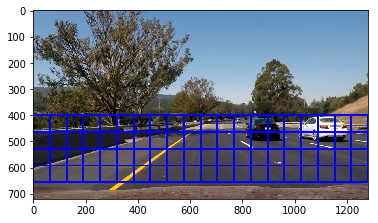

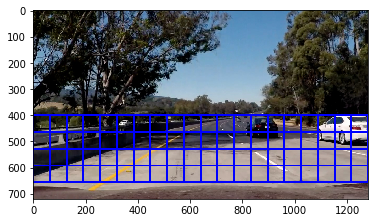

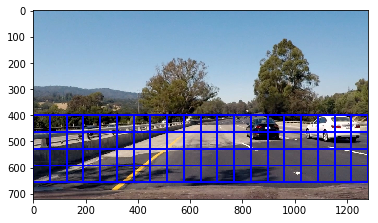

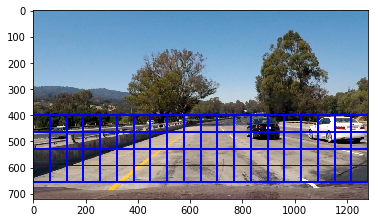

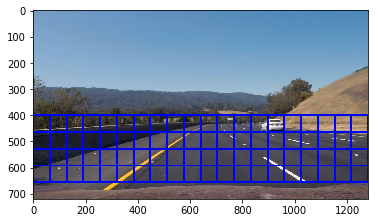

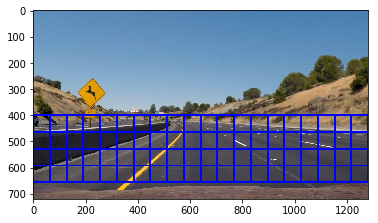

In [16]:
#Run classifier on test images

test_images = glob.glob('test_images/test*.jpg')

if DBG == True:
    print(test_images)

for img_src in test_images:
    #img = cv2.imread(img_src)
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    if DBG == True:
        print('####################################################')
        print('Processing image: ', img_src)
        print('####################################################')
    
    window_list = get_sliding_window_boxes(img,
                   y_start_stop=y_start_stop,
                   xy_window_size=(128, 128),
                   xy_overlap_size=(0.5, 0.5))
    
    if DBG == True:
        print('----------------------------------------------------')
        print('Len of Window List: ', len(window_list))
        print('----------------------------------------------------')
    
    hot_windows = search_windows_and_classify(img, window_list,
                                svc, X_scaler, color_space, spatial_size, 
                                hist_bins, orient, pix_per_cell,
                                cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat)

    if DBG == True:
        print('******************************************************')
        print('Len of Hot windows:', len(hot_windows))
        print('******************************************************')
    
    windowed_img = draw_boxes(draw_img, hot_windows)
    
    plt.figure()
    plt.imshow(windowed_img)
    

## HOG Sub-Sampling Window Search

In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [18]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img,  
              scale, 
              classifier,
              scaler,
              orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,
              y_start_stop):
    
    bounding_boxes = []
    
    #Copy the image
    #draw_img = np.copy(img)
    
    #Create heatmap
    #heatmap = np.zeros_like(img[:,:,0])
    
    #Normalize the image
    img = (img.astype(np.float32) / 255)
    
    #Define the bounding area where to search for bounding boxes/windows
    img_to_search = img[y_start_stop[0]:y_start_stop[1], :, :]
    
    #Convert image to different color space
    color_conv_img_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = color_conv_img_to_search.shape
        color_conv_img_to_search = cv2.resize(color_conv_img_to_search, 
                                              (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    
    channel_1 = color_conv_img_to_search[:,:,0]
    channel_2 = color_conv_img_to_search[:,:,1]
    channel_3 = color_conv_img_to_search[:,:,2]

    # Define blocks and steps as above
    nxblocks = (channel_1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (channel_1.shape[0] // pix_per_cell) - cell_per_block + 1

    
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    #Define steps in x and y direction (instead of overlap)
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog_feat_1 = get_hog_features(channel_1, orient, pix_per_cell, cell_per_block,
                               vis=False,
                               feature_vect=False)
    
    hog_feat_2 = get_hog_features(channel_2, orient, pix_per_cell, cell_per_block,
                               vis=False,
                               feature_vect=False)
    
    hog_feat_3 = get_hog_features(channel_3, orient, pix_per_cell, cell_per_block,
                               vis=False,
                               feature_vect=False)
    

    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            #Step to correct image sub-sample
            ypos = (yb * cells_per_step)
            xpos = (xb * cells_per_step)
            
            #Extract hog features from this patch using original hog
            hog_feat_1_scaled = hog_feat_1[ypos:(ypos+nblocks_per_window), xpos:(xpos+nblocks_per_window)].ravel()
            hog_feat_2_scaled = hog_feat_2[ypos:(ypos+nblocks_per_window), xpos:(xpos+nblocks_per_window)].ravel()
            hog_feat_3_scaled = hog_feat_3[ypos:(ypos+nblocks_per_window), xpos:(xpos+nblocks_per_window)].ravel()
            
            #Combine the three hog features
            hog_features = np.hstack((hog_feat_1_scaled, hog_feat_2_scaled, hog_feat_3_scaled))

            #Window position in pixels
            xleft = (xpos * pix_per_cell)
            ytop = (ypos * pix_per_cell)

            # Extract the image patch
            subimg = cv2.resize(color_conv_img_to_search[ytop:(ytop+window), xleft:(xleft+window)], (64,64))
          
            # Get Bin spatial and color histogram features
            bin_spatial_features = bin_spatial(subimg, size=spatial_size)
            
            #rhist, ghist, bhist, bin_centers, color_hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            color_hist_features = color_hist(subimg, hist_bins)



            #Combine all 3 features in same order as classifier (Bin spatial, color, HOG)
            features_total = np.hstack((bin_spatial_features, color_hist_features, hog_features))
            
            # Scale features and make a prediction
            test_features = scaler.transform(features_total.reshape(1, -1))
            
            #Make a prediction for this part of image
            test_prediction = classifier.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)

                top_left_point = (xbox_left, (ytop_draw + y_start_stop[0]))
                btm_rght_point = ((xbox_left + win_draw), (ytop_draw + y_start_stop[0] + win_draw))

                #cv2.rectangle(draw_img, top_left_point, btm_rght_point, (0,0,255), 6) 
                #heatmap[top_left_point[1] : btm_rght_point[1], top_left_point[0] : btm_rght_point[0]] += 1

                bounding_boxes.append((top_left_point, btm_rght_point))
                
    #return draw_img, heatmap, bounding_boxes
    return bounding_boxes



## Apply heatmap thresholding and labeling

In [19]:
# Add heat to image given a list of bounding boxes
def add_heat(heatmap, bbox_list):
    
    for box in bbox_list:
        
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [20]:
#Apply threshold to heatmaps
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

In [21]:
#Draw bounding boxes around label() images
def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        #Store the pixels where car is detected
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        
        #Create a bounding box from the above pixel values using min and max
        # Define a bounding box based on min/max x and y
        bounding_box = ( (np.min(nonzero_x), np.min(nonzero_y)), (np.max(nonzero_x), np.max(nonzero_y)) )
        
        # Draw the box on the image
        cv2.rectangle(img, bounding_box[0], bounding_box[1], (0,0,255), 6)

    return img

## Apply different window scales to detect cars

In [22]:
# Use a range of scales to identify cars near or far from camera
# Return a list of bounding boxes for different scales concatenated together

def find_cars_different_scales(img,
                              scales, 
                              classifier,
                              scaler,
                              orient, pix_per_cell, cell_per_block, 
                              spatial_size, hist_bins,
                              y_start_stop):
    
    total_bounding_box = []
    
    for scale in scales:
        bounding_boxes = find_cars(img, 
                            scale, classifier, scaler, 
                            orient, pix_per_cell, cell_per_block, 
                            spatial_size, hist_bins, y_start_stop)

        if len(bounding_boxes) > 0:
            total_bounding_box.append(bounding_boxes)
    
    
    if len(total_bounding_box) > 0:
        total_bounding_box = np.concatenate(total_bounding_box)
    
    return total_bounding_box



## Create Vehicle Detection Pipeline

In [25]:
def process_image(input_img):
    heat = np.zeros_like(input_img[:,:,0]).astype(np.float)
    
    
    bounding_boxes = find_cars_different_scales(input_img,
                              scales, 
                              svc,
                              X_scaler,
                              orient, pix_per_cell, cell_per_block, 
                              spatial_size, hist_bins,
                              y_start_stop)
    
    # Add heat from all the bounding boxes
    # Increase pixels values by 1 in heat if pixel is inside bounding box
    heat = add_heat(heat, bounding_boxes)

    #Apply threshold to heatmap so that only areas where most of the box are present is captured
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    #Draw final box on image consisting of car
    windowed_img = draw_labeled_bboxes(np.copy(input_img), labels)

    return windowed_img
    

## Test find_cars on test images

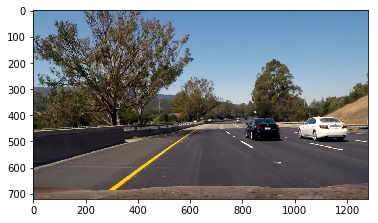

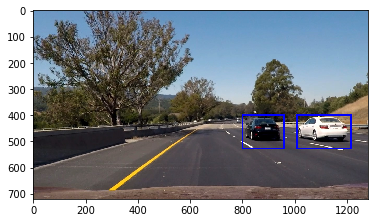

In [26]:
#for img_src in test_images:
img = mpimg.imread(test_images[0])
draw_img = process_image(img) 


plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(draw_img)

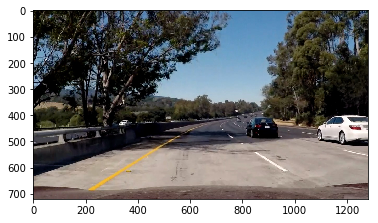

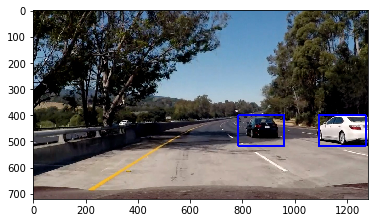

In [27]:
#for img_src in test_images:
img = mpimg.imread(test_images[1])
draw_img = process_image(img) 


plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(draw_img)

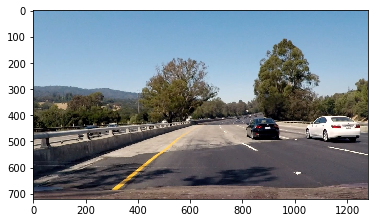

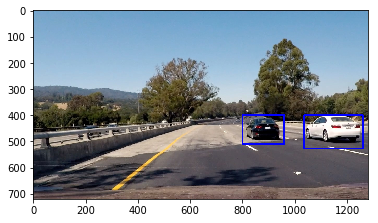

In [28]:
#for img_src in test_images:
img = mpimg.imread(test_images[2])
draw_img = process_image(img) 


plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(draw_img)

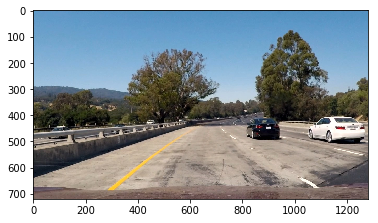

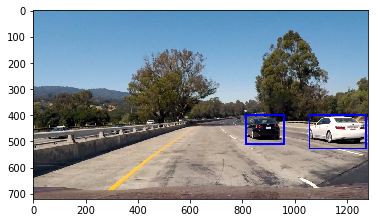

In [29]:
#for img_src in test_images:
img = mpimg.imread(test_images[3])
draw_img = process_image(img) 


plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(draw_img)

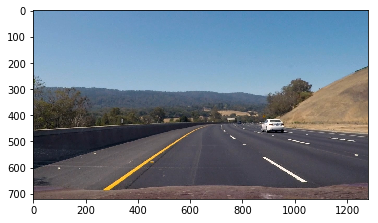

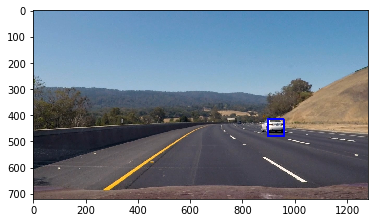

In [30]:
#for img_src in test_images:
img = mpimg.imread(test_images[4])
draw_img = process_image(img) 


plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(draw_img)

## Test pipeline on test video

In [271]:
video_output = 'test_video_output.mp4'

video_frame = VideoFileClip("test_video.mp4")
white_clip = video_frame.fl_image(process_image)

%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:27<00:02,  2.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 24s, sys: 2.51 s, total: 1min 27s
Wall time: 1min 28s


## Test pipeline on project video

In [31]:
video_output = 'project_video_output.mp4'

video_frame = VideoFileClip("project_video.mp4")
white_clip = video_frame.fl_image(process_image)

%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [49:48<00:02,  2.21s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 45min 2s, sys: 1min 20s, total: 46min 22s
Wall time: 49min 49s
